# 2.5D ResNet

This `.ipynb` will focus on the development of a 2.5D methodology for the previously used ResNet.

Instead of passing the same file to each RGB channel, I'll be working on a robust way to pass the entire batch as sets of 3 consecutive slices.

In [1]:
# ------------ Utils ------------

from newDimUtils import * 

c:\Users\hasht\anaconda3\envs\fibrosis\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Loads the dataframe
df_fibrosis = pd.read_pickle(r'..\..\..\\fibrosis_data.pkl')
df_annotations = df_fibrosis.drop(columns="SliceData")
df_annotations["SliceID"] = df_annotations["SliceID"].astype(str) + ".npy" # better for data loader
df_annotations.head()

,SliceID,Class
0,101__CT-0002-0001.npy,0
1,101__CT-0002-0002.npy,0
2,101__CT-0002-0003.npy,0
3,101__CT-0002-0004.npy,0
4,101__CT-0002-0005.npy,0


## New Data Loader

The new data loader must be capable of correctly recognizing and assigning consecutive patient-wise slices. It also needs to identify the first and last slices, in order to duplicate them for the previous and next examples, respectively.

This is mostly done through indexing of the `.csv`, which I had previously organized. Each patient and consecutive slice is always aggregated, further facilitating the data loader's task.

In [3]:
class FibrosisDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, albumentations=None, gauss=False):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.albumentations = albumentations
        self.gauss = gauss
        self.number_images = 0

    def __len__(self):
        return len(self.img_labels)
    

    def __getitem__(self, idx):
        # idx represents index

        # Locates each image in the csv file
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        if not os.path.exists(img_path): print(f"Missing file: {img_path}")

        # Fetches entire slice name
        slice_id = self.img_labels.iloc[idx, 0]

        # Parses patient ID for each slice
        patient_id = getPatientID(slice_id)

        # Get current slice info and class
        curr_img = np.load(img_path)
        label = self.img_labels.iloc[idx, 1]


        # This function can fetch any additional slice
        def load_image(i):
            row = self.img_labels.iloc[i]
            path = os.path.join(self.img_dir, row[0])
            img = np.load(path).astype(np.float32)
            label = row[1]
            return img, label, row[0]

        
        # Fetches previous slice
        if (idx > 0) and getPatientID(self.img_labels.iloc[idx - 1, 0]) == patient_id:
            prev_img, _, _ = load_image(idx - 1)
        else: prev_img = curr_img  # Duplicates slice if it's the first, uses as previous 
        
        # Try to get next slice
        if (idx < len(self.img_labels) - 1) and getPatientID(self.img_labels.iloc[idx + 1, 0]) == patient_id:
            next_img, _, _ = load_image(idx + 1)
        else: next_img = curr_img  # Duplicates slice if it's the last, uses as next 
        
        # Finally, stacks them into RGB: shape → (3, H, W)
        image = np.stack([prev_img, curr_img, next_img], axis=0)

        # Reorder: shape → (H, W, 3)
        image = np.transpose(image, (1, 2, 0))  # Now it looks like an RGB image

        # Adds randomly selected gauss noise or blur
        if self.gauss:
            # Gaussian Noise
            scale_choice = random.choice(range(10,40))
            gauss_noise_choice = np.random.normal(loc=0, scale=scale_choice, size=image.shape)
            noise_stack = image + gauss_noise_choice  # NumPy broadcasting, remains np.ndarray
            
            # Gaussian Blur
            
            # random value between 1.0 and 1.5 (inclusive) in steps of 0.1
            sigma_choice = (random.choice(range(10,16))/10)

            # : : c explicitly avoids merging channels, as it only chooses each 2D array
            # essentially skips Height and Width: (H, W, 3) → acts only on "3" → each color channel
            blur_stack = np.stack(
                [gaussian_filter(image[:, :, c], sigma=sigma_choice) for c in range(3)],
                axis=2 # acts on index==2 → colors
            )

            # Random Choice
            gauss_choice = random.choice((0,1))
            if gauss_choice == 0: 
                print("NOISE")
                image = noise_stack
            elif gauss_choice == 1: 
                print("BLUR")
                image = blur_stack
            
    
        # Guarantee compatibility
        if self.gauss or self.albumentations: 
            image = image.astype(np.float32)

        # Already has resize prior to augments
        if self.albumentations:
            stacked_aug = self.albumentations(image=image)
            image = stacked_aug['image']

        # Applies necessary ResNet input transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label, patient_id

In [5]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
])


# Augmentations
augment = A.Compose([
    # Applies resize prior to augmentations
    # Could hinder scan quality, but drastically improves training speed
    A.Resize(224, 224),
    # Rotate
    A.Rotate(limit=(-350,30), p=0.8),
    # Translate
    A.Affine(translate_percent={"x":(-0.15,0.15), "y":{-0.23,0.25}},
              rotate=0, scale=1, p=0.8),
    # Shear
    A.Affine(shear={"x":(-15,15), "y":(-15,15)},p=0.8)
])

# Randomized Gaussian Noise and Blur
gauss = True

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=augment, gauss=gauss)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

In [6]:
warnings.filterwarnings("ignore")

checkShape(train_dataset, df_fibrosis)

SliceID at index 1136: 65__CT-7444-0008.npy

Original np.array shape:
(512, 512)
----------------------

Transformed tensor shape:
NOISE
torch.Size([3, 224, 224])


SliceID at index 286: 128__CT-0007-0038.npy
BLUR
(224, 224, 3)


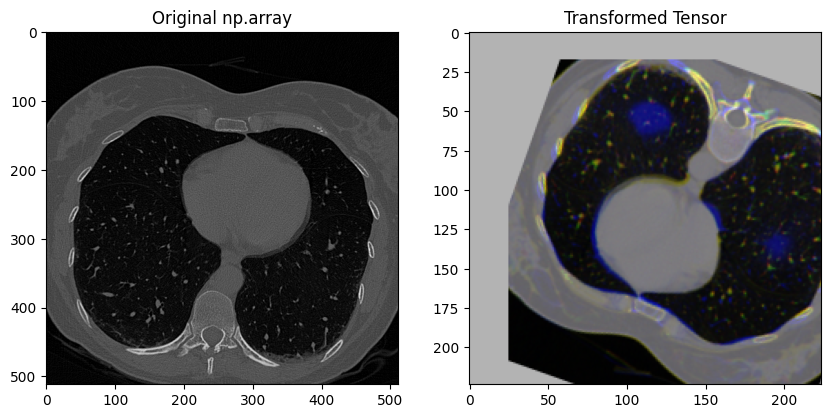

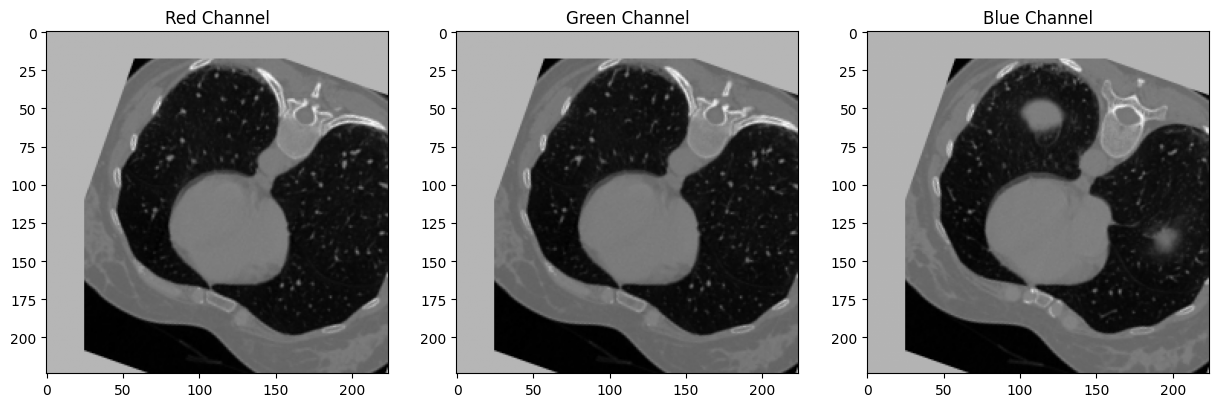

In [7]:
tensorVSnp(train_dataset, df_fibrosis)

The next step is to **run every experiment again...**